In [15]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(os.path.abspath(os.path.join('..', '..', 'xbeach-toolbox')))

In [2]:
## import specific tools from xbTools
from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend, lateral_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general import wave_functions, visualize_mesh

In [182]:
import pandas as pd

# Process bathy profiles


profile_path = '/home/alson/models/xbeach-toolbox/examples/kld_profiles4.xlsm'

# read the excel file with profiles (colummns are x,easting, northing,depth,dtmx)
df = pd.read_excel(profile_path, header=None)
df = df.rename(columns={'0': 'x', '1': 'depth'})
# print(df)
# create a dictionary to store all dataframes
dfs = {}

# loop through all sheets
for i in range(1, 69):
    sheet_name = f'PR_{i:02d}'  # format the sheet name
    df = pd.read_excel(profile_path, sheet_name=sheet_name, header=None)
    # print(df)
    df.columns = ['x', 'northing','easting', 'depth','dtmx', 'dtmnorthing','dtmeasting', 'dtmdepth']  # Assign meaningful column names

    # Interpolate 'depth' values based on 'x' values with a difference of 1
    x_min = 0
    x_max = df['x'].max()
    new_x = np.arange(x_min, x_max + 1, 1)
    dtmx_min = 0
    dtmx_max = df['x'].max()
    new_dtmx = np.arange(dtmx_min, dtmx_max + 1, 1)


    # Perform linear interpolation
    interpolated_depth = np.interp(new_x, df['x'], df['depth'])

    # Create a new DataFrame with interpolated values
    # interpolated_df = pd.DataFrame({'x': new_x, 'depth': interpolated_depth})

        # Perform linear interpolation
    interpolated_dtmdepth = np.interp(new_dtmx, df['dtmx'], df['dtmdepth'])

    # Create a new DataFrame with interpolated values
    # interpolated_dtmdf = pd.DataFrame({'dtmx': new_dtmx, 'dtmdepth': interpolated_dtmdepth})
# 
    interpolated_df = pd.DataFrame({'x': new_x, 'depth': interpolated_depth}).set_index('x')
    interpolated_dtmdf = pd.DataFrame({'dtmx': new_dtmx, 'dtmdepth': interpolated_dtmdepth}).set_index('dtmx')

    # Choose the maximum between 'depth' and 'dtmdepth' for each corresponding index
    merged_df = pd.DataFrame({'merged_depth': interpolated_df['depth'].combine(interpolated_dtmdf['dtmdepth'], max)})
    
    # Store the merged DataFrame in the dictionary merged to extract later
    dfs[sheet_name] = merged_df



    # plt.plot(merged_df['merged_depth'])
    # plt.plot(interpolated_df['depth'])
    # plt.plot(interpolated_dtmdf['dtmdepth'])
    # Print the interpolated DataFrame
    # print(interpolated_df)
    # print(interpolated_dtmdf)





    # dfs[sheet_name] = df  # store the dataframe in the dictionary
print(dfs)

{'PR_01':        merged_depth
0.0        0.974797
1.0        0.964504
2.0        0.958500
3.0        0.990729
4.0        0.960967
...             ...
388.0    -23.354256
389.0    -23.343663
390.0    -23.330390
391.0    -23.316197
392.0    -23.309690

[393 rows x 1 columns], 'PR_02':        merged_depth
0.0        1.134529
1.0        1.198572
2.0        1.158820
3.0        1.122483
4.0        1.099814
...             ...
449.0    -33.785243
450.0    -34.010352
451.0    -34.089019
452.0    -34.425580
453.0    -34.517330

[454 rows x 1 columns], 'PR_03':        merged_depth
0.0        3.919000
1.0        3.525386
2.0        3.059843
3.0        2.517403
4.0        2.715535
...             ...
382.0    -38.900258
383.0    -38.917915
384.0    -38.939096
385.0    -39.003523
386.0    -39.114437

[387 rows x 1 columns], 'PR_04':        merged_depth
0.0        1.352532
1.0        1.388151
2.0        1.424190
3.0        1.452712
4.0        1.495847
...             ...
415.0    -44.701201
416.0   

1.696060647468376


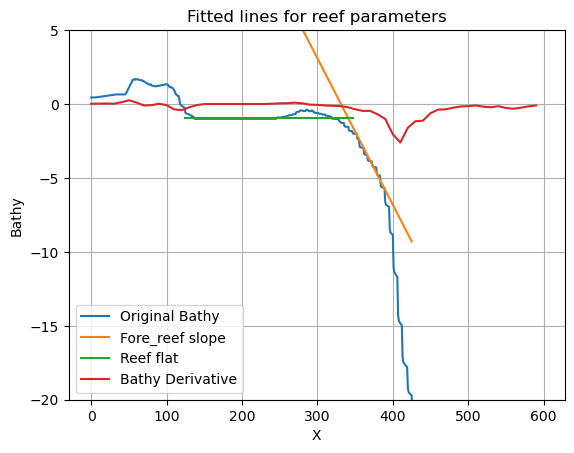

In [183]:
# loop through all profiles and get physical parameters for BEWARE interpolation
for i in range(41, 42): # total of 68 profiles for Kulhudhuffushi island
    sheet_name = f'PR_{i:02d}'  # format the sheet name
    ## load data
    bathy_df = dfs[sheet_name]
    # Extract depths from the DataFrame and convert to numpy array
    bathy = bathy_df['merged_depth'].values
    x=bathy_df['merged_depth'].index.values
    # print(x)
    # Define the subset range
    subset_indices = np.where((bathy >= -6) & (bathy <= -3.5)) # pretty arbitrary values but they work for most of the profiles here
    flat_indices = np.where((bathy >= -2) & (bathy <= -0.4)) #for reef flat values
    plot_indices = np.where((bathy >= -20) & (bathy <= 0)) #for plotting the fore reef slope
    
    
    # Fit a straight line to the forereef subset
    coefficients = np.polyfit(x[subset_indices], bathy[subset_indices], 1)
    line_fit = np.poly1d(coefficients)

    # Fit a straight line to the flat subset (some reef flats are sloped)
    flat_depth = np.mean(bathy[flat_indices]) #taking an average of depths between -0.4 and -2m
    flat_fit = np.poly1d(np.array([0,flat_depth])) # this is not required but left in case the approach changes

    # Plot the original bathy data
    plt.plot(x, bathy, label='Original Bathy')

    #Beach Crest Elevation
    beach_indices = np.where((bathy >= 0)) # pretty arbitrary values but they work for most of the profiles here
    crest_elevation=np.max(bathy[beach_indices])

    print(crest_elevation)
    # Calculate the derivative of bathy values
    bathy_derivative = np.gradient(bathy[::10], x[::10])

    # Plot the fitted straight line for the forereef
    plt.plot(x[plot_indices], line_fit(x[plot_indices]), label='Fore_reef slope')

    # Plot the fitted straight line for the reef flat
    plt.plot(x[flat_indices], flat_fit(x[flat_indices]), label='Reef flat')

    # Plot the differentiation of bathy values
    plt.plot(x[::10], bathy_derivative*5, label='Bathy Derivative')

    # Plot settings
    plt.xlabel('X')
    plt.ylabel('Bathy')
    plt.title('Fitted lines for reef parameters')
    plt.legend()
    plt.grid(True)
    plt.ylim(-20,5)
    plt.show()



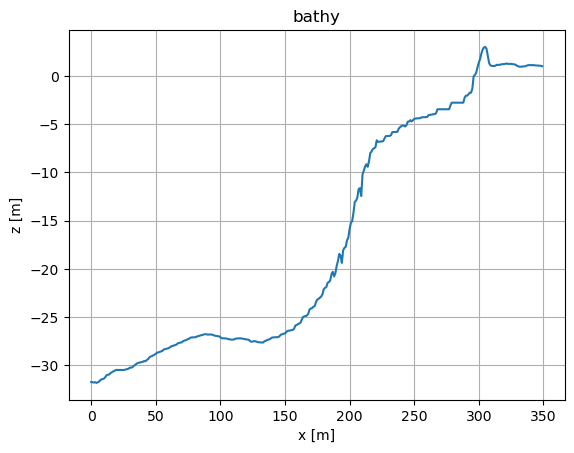

In [6]:
# Initialize an empty list to store depths and corresponding x values
bathy_list = []

for i in range(37, 38):
    sheet_name = f'PR_{i:02d}' 

    ## load data
    bathy_df = dfs[sheet_name]
    # Extract depths from the DataFrame and convert to numpy array
    bathy = bathy_df['merged_depth'].values
    # Reverse the bathy values
    bathy = np.flip(bathy)

    ## set bathy grid
    nx = len(bathy)
    # ny = 72
    dx = 1
    # dy = 20

    x = np.linspace(0,(nx-1)*dx,nx)

    ## plot
    plt.figure()
    plt.plot(x,bathy)
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    plt.grid('on')
    plt.title('bathy')

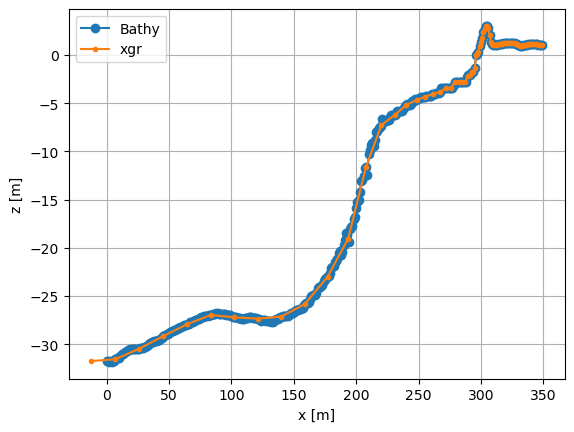

In [9]:
xgr,zgr = xgrid(x, bathy,dxmin=1)


plt.figure()
plt.plot(x,bathy,'-o')
plt.plot(xgr,zgr,'.-')
plt.legend(['Bathy','xgr'])
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.grid('on')

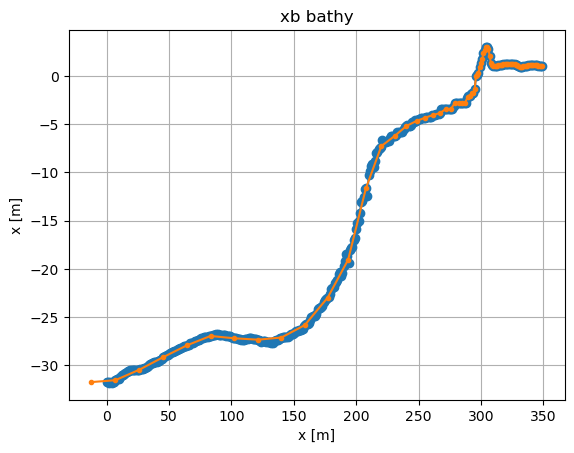

In [10]:
zgr = np.interp(xgr, x, bathy)

plt.figure()
plt.plot(x,bathy,'-o')
plt.plot(xgr,zgr,'.-')
plt.xlabel('x [m]')
plt.ylabel('x [m]')
plt.title('xb bathy')
plt.grid('on')

Text(0, 0.5, 'z [m]')

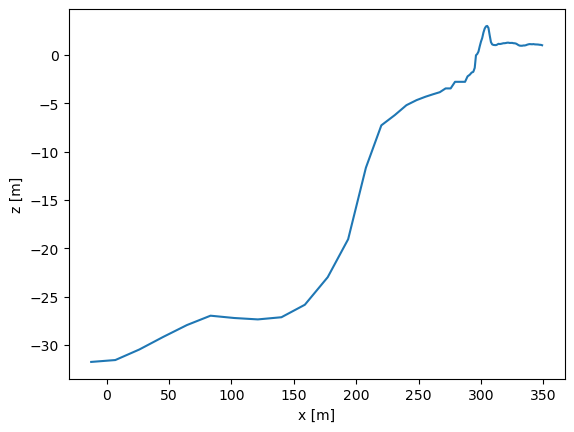

In [11]:
xgr, ygr, zgr = seaward_extend(xgr,[0],zgr,slope=1/20000000000000000,depth=min(zgr))
plt.figure()
plt.plot(xgr.T,zgr[:,:].T)
plt.xlabel('x [m]')
plt.ylabel('z [m]')

In [12]:
xb_setup = XBeachModelSetup('Test kld')

# print(xb_setup)

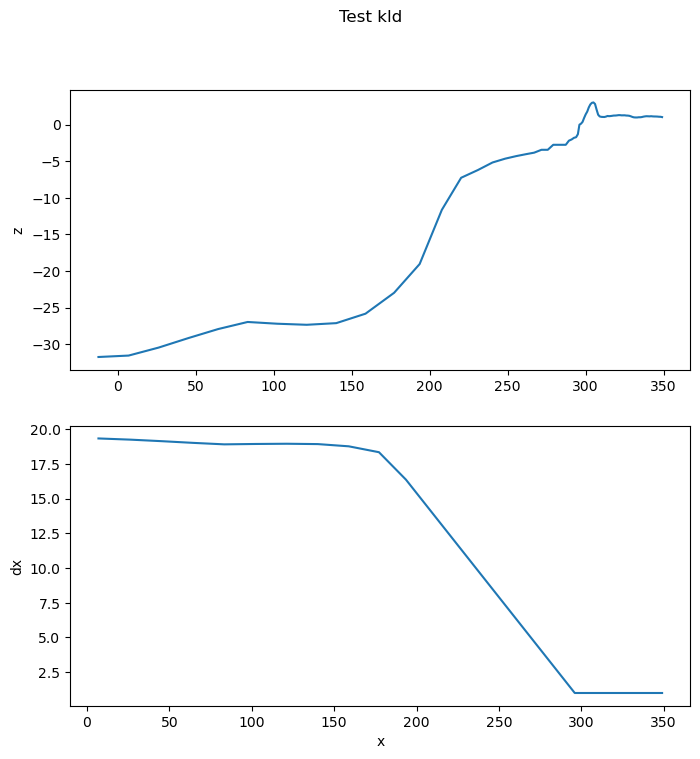

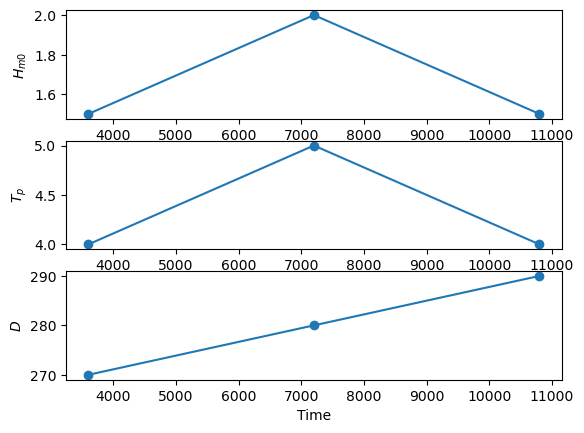

In [13]:
xb_setup.set_grid(xgr,None,zgr,posdwn=-1)

# xb_setup.set_waves('parametric',{'Hm0':2, 'Tp':5, 'mainang':270, 'gammajsp':3.3, 's' : 10000, 'fnyq':1})
xb_setup.set_waves('jonstable',{'Hm0':[1.5, 2, 1.5],'Tp':[4, 5, 4],'gammajsp':[3.3, 3.3, 3.3], 's' : [20,20,20], 'mainang':[270,280, 290],'duration':[3600, 3600, 3600],'dtbc':[1,1,1]})

xb_setup.set_params({'wavemodel':'surfbeat',
                     'morphology':0,
                     'befriccoef':0.01,
                     'tstop':3600,
                     'zs0':0,
                     'nglobalvar':['zb','zs','H'],
                     'npointvar':['zs','zb'],
                     'nmeanvar':['zb'],
                     'sedtrans':0,
                     'instat':'jons',
                     'npoints':['1 0', '6 0', '10 0', '12 0']})

sim_path = os.path.join('xb-1D')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)
xb_setup.write_model(sim_path)

In [14]:
print(sim_path)
print

xb-1D


In [15]:
xb_setup = XBeachModelSetup('Test kld')
import os


# Define the path to xbeach.exe
xbpath = r'C:\Users\Rendering\Downloads\xbeach_5848_x64_mpi_netcdf\xbeach.exe'

def create_runxb_bat(xbpath, bat_file_path):
    # Define the content of the batch file
    batch_content = f'mpiexec -np 16 -localonly "{xbpath}"'

    # Write the content to runxb.bat file
    with open(bat_file_path, 'w') as file:
        file.write(batch_content)

# Define the path for the runxb.bat file
bat_file_path = os.path.join(sim_path, 'runxb.bat')

# Create runxb.bat file
create_runxb_bat(xbpath, bat_file_path)


def copy_mpiexec(path_sim):
    # Assuming mpiexec.exe is in the current working directory
    source = 'C:/Users/alson/OneDrive/Documents/mpiexec.exe'
    shutil.copy(source, path_sim)


# # Create runxb.bat file
# create_runxb_bat(xbpath)

# Define the destination folder to copy mpiexec.exe
destination_folder = os.path.dirname(sim_path)

# Copy mpiexec.exe to the destination folder
copy_mpiexec(sim_path)

print('success')


NameError: name 'shutil' is not defined

In [ ]:
import subprocess

# Run the batch file as administrator
subprocess.run(['runas', '/user:Administrator', bat_file_path])

CompletedProcess(args=['runas', '/user:Administrator', 'xb-1D\\runxb.bat'], returncode=1)

In [39]:
sim_path = r'D:\KLD'
bathy_df = dfs['PR_08']
# Extract depths from the DataFrame and convert to numpy array
bathy = bathy_df['merged_depth'].values
bathy[2:12]=bathy[2:12]-100
print(zgr[0,0])
# plt.xlim([0,100])
# plt.ylim([-1,4])
print(len(xgr[0]))

-59.5645675659179
35


In [184]:
import os
import shutil
from xbTools.xbeachtools import XBeachModelSetup

def create_runxb_bat(xbpath, bat_file_path):
    # Define the content of the batch file
    batch_content = f'mpiexec -np 30 -mapall "{xbpath}"'

    # Write the content to runxb.bat file
    with open(bat_file_path, 'w') as file:
        file.write(batch_content)




def copy_mpiexec(path_sim):
    # Assuming mpiexec.exe is in the current working directory
    source = '/mnt/d/KLD/mpiexec.exe'
    shutil.copy(source, path_sim)

# Define the ranges for each variable
Hm0_range = np.arange(1, 3.1, 0.5)
Tp_range = np.arange(5, 16, 5)
cf_values = [0.01, 0.1]
zs0_range = np.arange(0, 1.61, 0.2)

# Nested loop through each variable
for Hm0 in Hm0_range:
    for Tp in Tp_range:
        for cf in cf_values:
            for zs0 in zs0_range:

                
                # Initialize an empty list to store depths and corresponding x values
                bathy_list = []
                for i in range(41, 42,4):
                    sheet_name = f'PR_{i:02d}' 
                    # Generate folder name based on variable values
                    folder_name = f'{sheet_name}+Hs={Hm0:.3g}-Tp={Tp:.3g}-cf={cf:.3g}-zs0={zs0:.3g}'
                    ## load data
                    bathy_df = dfs[sheet_name]
                    # Extract depths from the DataFrame and convert to numpy array
                    bathy = bathy_df['merged_depth'].values
                    # bathy[2:12]=bathy[2:12]-100 #reduce the depths to find the discharge volume
                    # Reverse the bathy values
                    bathy = np.flip(bathy)

                    ## set bathy grid
                    nx = len(bathy)
                    dx = 1

                    x = np.linspace(0, (nx-1)*dx, nx)
                    xgr, zgr = xgrid(x, bathy, dxmin=1.2)
                    # xgr=x
                    # zgr=bathy
                    zgr = np.interp(xgr, x, bathy)
                    xgr, ygr, zgr = seaward_extend(xgr, [0], zgr, slope=1/20, depth=min(zgr))
                    
                    # # Example arrays
                    # xgr = np.append(xgr,[[xgr[0,-1]+1, xgr[0,-1]+2, xgr[0,-1]+3, xgr[0,-1]+4]])  # Example array with dimensions (1, 3)
                    # zgr = np.append(zgr, [[-200, -200, 5,5]])  # Example array with dimensions (1, 3)





                    xb_setup = XBeachModelSetup('Test kld')
                    xb_setup.set_grid(xgr, None, zgr, posdwn=-1)

                    xb_setup.set_waves('parametric', {'Hm0': Hm0, 'Tp': Tp, 'mainang': 270, 'gammajsp': 3.3, 's': 10000, 'fnyq': 1})
                    # xb_setup.set_waves('jonstable',{'Hm0':Hm0,'Tp':Tp,'gammajsp':[3.3], 's' : [20], 'mainang':[270],'duration':[3600],'dtbc':[1]})

                    xb_setup.set_params({'wavemodel': 'nonh',
                                         'nonh': '1',
                                         'secorder': '1',
                                         'nhbreaker': '1',
                                         'instat':'jons',
                                         'front':'nonh_1d',
                                         'back':'wall',
                                         'ARC': '1',
                                         'order': '1',
                                         'CFL': '0.3',
                                         'morphology': 0,
                                         'befriccoef': cf,
                                         'tstop': 3600,
                                         'zs0': zs0,
                                         'nglobalvar': ['zb', 'zs','u'],
                                         'nmeanvar': ['zb'],
                                         'sedtrans': 0,
                                         'tintg' : 1,
                                         'tintp' : 1,
                                         })

                    sim_path = os.path.join('/mnt/d/KLD/NW mod', folder_name)
                    print(sim_path)
                    if not os.path.exists(sim_path):
                        os.makedirs(sim_path)  # Use makedirs to create nested directories
                    xb_setup.write_model(sim_path)
                    # Define the path to xbeach.exe
                    xbpath = r'D:\KLD\XBeach_Kingsday\xbeach.exe'

                    # Define the path for the runxb.bat file
                    bat_file_path = os.path.join(sim_path, 'runxb.bat')

                    # Create runxb.bat file
                    create_runxb_bat(xbpath, bat_file_path)


                    # # Create runxb.bat file
                    # create_runxb_bat(xbpath)

                    # Define the destination folder to copy mpiexec.exe
                    destination_folder = os.path.dirname(sim_path)

                    # Copy mpiexec.exe to the destination folder
                    copy_mpiexec(sim_path)

                    params_file_path = os.path.join(sim_path, 'params.txt')

                    # Open the text file in read mode because this stupid xbtools package is so limited
                    with open(params_file_path, 'r') as file:
                        lines = file.readlines()

                    # Insert new lines after the 28th line
                    lines.insert(27, 'instat = jons\n')
                    lines.insert(28, 'ARC = 1\n')
                    lines.insert(29, 'nhbreaker = 1\n')
                    lines.insert(30, 'secorder = 1\n')

                    # Open the text file in write mode and write the modified lines
                    with open(params_file_path, 'w') as file:
                        file.writelines(lines)
                    print('success')
                    plt.close('all')



/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.2
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.4
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.6
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.8
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.2
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.4
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.6
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0
wbctype=parametric cannot be plotted
success
/mnt/d/KLD/NW mod/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0.2
wbctype=

In [150]:
import os

def delete_mpich_exe(directory):
    # Iterate over each folder in the specified directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is named "mpich.exe"
            # print(file)
            if file == "mpiexec.exe":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                print(file_path)
                try:
                    # Delete the file
                    os.remove(file_path)
                    print(f"Deleted {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")

# Specify the directory to search
directory_to_search = '/mnt/d/KLD/NW profile/complete'

# Call the function to delete mpich.exe from each folder in the specified directory
delete_mpich_exe(directory_to_search)

/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.2/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.2/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.4/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.4/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.6/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.6/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.8/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=0.8/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=1/mpiexec.exe
Deleted /mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-cf=0.01-zs0=1/mpiexec.exe
/mnt/d/KLD/NW profile/complete/PR_41+Hs=1-Tp=10-

In [13]:
print(sim_path)

/mnt/d/KLD/PR_68+Hs=3-Tp=15-cf=0.1-zs0=1.6


In [19]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..')))

from xbTools.xbeachpost import XBeachModelAnalysis
results = XBeachModelAnalysis('Test kld', '/examples/xb-1D/')
results.metadata

AssertionError: missing params.txt

loading model output coordinates from file
loading variable zs from file
None
loading variable point_zs from file
[[[0.0 0.0 0.0 ... -- -- --]]

 [[2.7318273591307448e-05 3.6922968768609525e-05 1.9544798773500468e-06
   ... 0.9631616648016449 -- --]]

 [[0.00014622172609823718 0.00017226252030701255 2.955243026889504e-05
   ... 0.9631616648016449 -- --]]

 ...

 [[0.005611864594385663 0.0057360838628522206 0.02021909742060482 ...
   0.9631616648016449 -- --]]

 [[0.008726349476208997 0.009428303687625286 0.028693751127729986 ...
   0.9631616648016449 -- --]]

 [[0.015271408886182275 0.01665422447703537 0.03607694527524885 ...
   0.9631616648016449 -- --]]]


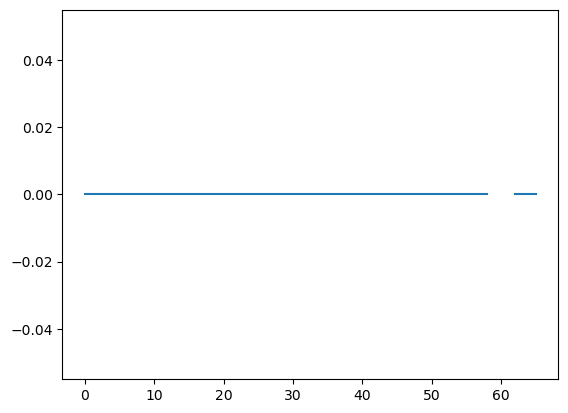

KeyboardInterrupt: 

In [109]:
zs = results.load_modeloutput('zs')
print(zs)
ny, nx = results.var['globalx'].shape

results.load_modeloutput('point_zs')

zs = results.get_modeloutput('zs')
point_zs = results.get_modeloutput('point_zs')
print(zs)
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

# Assuming zs is a 2D numpy array
line, = ax.plot(zs[0, 0])

def update(num):
    line.set_ydata(zs[num, 0])  # update the data.
    return line,

for g in range(0,3600):
    ani = animation.FuncAnimation(fig, update, frames=range(3600), interval=100, blit=True)

    plt.show()


[[0.6407926581549818]
 [0.8874116120153563]
 [--]
 [0.48663060660552493]
 [--]
 [0.9161434353205622]
 [0.5918955913518339]
 [--]
 [--]
 [--]
 [--]
 [--]
 [0.3921632303875383]
 [--]
 [0.696305015785703]
 [0.8117762487632525]
 [--]
 [--]
 [0.08668347884985661]
 [0.01193579638983755]
 [--]
 [--]
 [0.9658526875715345]
 [--]
 [0.27954724294124744]
 [--]
 [--]
 [0.0746614801738189]
 [0.7865644677368235]
 [--]
 [0.36678317422380025]
 [--]
 [0.6965072583993243]
 [0.9889479456932216]
 [0.4955708829726174]
 [0.09155677426839226]
 [--]
 [0.0416299475162647]
 [0.0957092115803656]
 [0.31774385493268553]
 [--]
 [--]
 [0.09808466549417638]
 [--]
 [--]
 [--]
 [0.3596589625012969]
 [--]
 [--]
 [--]
 [--]
 [0.20785029194776772]
 [0.5624549188217096]
 [--]
 [0.7304249127720488]
 [--]
 [0.31832124196425593]
 [--]
 [0.7897472710384268]
 [--]
 [0.6081360313028504]
 [--]
 [0.4092566162013558]
 [--]
 [--]
 [0.16292722410070748]
 [--]
 [--]
 [--]
 [0.8370625994542165]
 [--]
 [--]
 [--]
 [--]
 [0.30215393201722

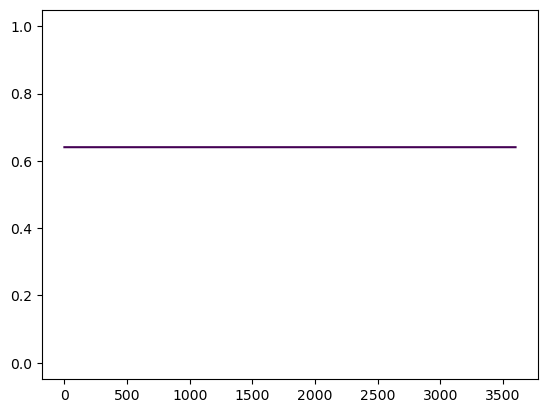

In [15]:
## change coordinates of plots to local coordinates:
#results.set_plot_localcoords(True)
## only plot a certain Area Of Interest of the complete grid
#results.set_aoi([20,445,20,220])

# example usage map plotting
# fig, ax = results.fig_cross_var('zs','[m]')
fig, ax = results.fig_profile_change(iy=0)

# #fig, ax = results.fig_map_diffvar('zb', '$\Delta z_b$ [m]')

# fig, ax = results.fig_cross_var('H', 2, iy=5, coord=None, plot_ref_bathy=True, zmin=-25)

# fig, ax = results.fig_profile_change(iy=5)

NameError: name 'results' is not defined

In [238]:
import os
import xarray as xr
import numpy as np

# Define the ranges for each variable
Hm0_range = np.arange(1, 2.6, 0.5)
Tp_range = np.arange(5, 16, 5)
cf_values = [0.01, 0.1]
zs0_range = np.arange(0, 1.6, 0.2)

# Initialize an empty dictionary to store results
results_dict = {}

# Nested loop through each variable
for Hm0 in Hm0_range:
    for Tp in Tp_range:
        for cf in cf_values:
            for zs0 in zs0_range:
                
                # Initialize an empty list to store depths and corresponding x values
                bathy_list = []
                for i in range(56, 57,4):
                    sheet_name = f'PR_{i:02d}' 
                    # Generate folder name based on variable values
                    folder_name = f'{sheet_name}+Hs={Hm0:.3g}-Tp={Tp:.3g}-cf={cf:.3g}-zs0={zs0:.3g}'
                    ## load data
                    bathy_df = dfs[sheet_name]
                    # Extract depths from the DataFrame and convert to numpy array
                    bathy = bathy_df['merged_depth'].values
                    # Reverse the bathy values
                    bathy = np.flip(bathy)

                    ## set bathy grid
                    nx = len(bathy)
                    dx = 1

                    x = np.linspace(0, (nx-1)*dx, nx)
                    sim_path = os.path.join('/mnt/d/KLD/complete', folder_name)
                    print(sim_path)

                    try:
                        # Define the path for the runxb.bat file
                        bat_file_path = os.path.join(sim_path, 'runxb.bat')

                        destination_folder = os.path.dirname(sim_path)

                        params_file_path = os.path.join(sim_path, 'params.txt')
                        xboutput_file_path = os.path.join(sim_path, 'xboutput.nc')
                        data = xr.open_dataset(xboutput_file_path)
                        zb100 = data.zb.sel(globaltime=100)

                        if i == 56 or i== 47:  # Adjust for profile 56
                            flat_indices = np.where((zb100.values[0] >= -5.5) & (zb100.values[0] <= -3.5))
                        else:
                            flat_indices = np.where((zb100.values[0] >= -2) & (zb100.values[0]<= -0.4))  

                        # output_point = flat_indices[0][-1]
                        output_point = 55
                        flat_depth = np.mean(bathy[flat_indices])
                        flat_fit = np.poly1d(np.array([0, flat_depth]))     

                        model_time = data.globaltime.values
                        water_level = data.zs.isel(globalx=output_point)
                        water_level_init = data.zs.isel(globalx=1)
                        bed_level = data.zb.isel(globalx=output_point)
                        Hs = 4 * np.sqrt(np.var(water_level.values))
                        Setup = np.mean(water_level.values) - np.mean(water_level_init.values)
                        
                        # Store results in the dictionary with a tuple key
                        key = (sheet_name, Hm0, Tp, cf, zs0)
                        results_dict[key] = {'Setup': Setup, 'Hs': Hs}
                        print('works')

                    except FileNotFoundError:
                        print(f"Folder '{folder_name}' not found. Skipping...")
                        continue

/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=0
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=0.2
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=0.4
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=0.6
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=0.8
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=1
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=1.2
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.01-zs0=1.4
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=0
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=0.2
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=0.4
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=0.6
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=0.8
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=1
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=1.2
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=5-cf=0.1-zs0=1.4
works
/mnt/d/KLD/complete/PR_56+Hs=1-Tp=10-cf=0.01-zs0=0
works
/mnt/d/KLD/complete/PR_56+Hs=1-

In [186]:
import os
import xarray as xr
import numpy as np

# Define the ranges for each variable
Hm0_range = np.arange(1, 2.6, 0.5)
Tp_range = np.arange(5, 16, 5)
cf_values = [0.01, 0.1]
zs0_range = np.arange(0, 1.61, 0.2)

# Initialize an empty dictionary to store results
overtop_dict = {}

# Nested loop through each variable
for Hm0 in Hm0_range:
    for Tp in Tp_range:
        for cf in cf_values:
            for zs0 in zs0_range:
                
                # Initialize an empty list to store depths and corresponding x values
                bathy_list = []
                for i in range(41, 42,4):
                    sheet_name = f'PR_{i:02d}' 
                    # Generate folder name based on variable values
                    folder_name = f'{sheet_name}+Hs={Hm0:.3g}-Tp={Tp:.3g}-cf={cf:.3g}-zs0={zs0:.3g}'
                    ## load data
                    bathy_df = dfs[sheet_name]
                    # Extract depths from the DataFrame and convert to numpy array
                    bathy = bathy_df['merged_depth'].values
                    # Reverse the bathy values
                    bathy = np.flip(bathy)

                    ## set bathy grid
                    nx = len(bathy)
                    dx = 1

                    x = np.linspace(0, (nx-1)*dx, nx)
                    sim_path = os.path.join('/mnt/d/KLD/NW mod/complete', folder_name)
                    print(sim_path)

                    try:
                        # Define the path for the runxb.bat file
                        bat_file_path = os.path.join(sim_path, 'runxb.bat')

                        destination_folder = os.path.dirname(sim_path)

                        params_file_path = os.path.join(sim_path, 'params.txt')
                        xboutput_file_path = os.path.join(sim_path, 'xboutput.nc')
                        data = xr.open_dataset(xboutput_file_path)
                        zb100 = data.zb.sel(globaltime=100)

                        if i == 56 or i== 47:  # Adjust for profile 56
                            flat_indices = np.where((zb100.values[0] >= -5.5) & (zb100.values[0] <= -3.5))
                        else:
                            flat_indices = np.where((zb100.values[0] >= -2) & (zb100.values[0]<= -0.4))  

                        output_point = flat_indices[0][-1]
                        flat_depth = np.mean(bathy[flat_indices])
                        flat_fit = np.poly1d(np.array([0, flat_depth]))     

                        model_time = data.globaltime.values
                        water_level = data.zs.isel(globalx=output_point)
                        
                        water_level_init = data.zs.isel(globalx=1)
                        bed_level = data.zb.isel(globalx=output_point)
                        Hs = 4 * np.sqrt(np.var(water_level.values))
                        Setup = np.mean(water_level.values) - np.mean(water_level_init.values)
                        end_point = 222
                        velocity = data.u.isel(globalx=end_point)
                        water_level_end = data.zs.isel(globalx=end_point)
                        zbo=data.zb.isel(globalx=end_point)
                        OD=np.sum(velocity.values*(water_level_end-zbo))/3600
                        # Store results in the dictionary with a tuple key
                        zs0_formatted = "{:.2g}".format(zs0)
                        key = (sheet_name, Hm0, Tp, cf, zs0_formatted)
                        
                        overtop_dict[key] = {'Setup': Setup, 'Hs': Hs,'OD': OD}
                        print('works')

                    except FileNotFoundError:
                        print(f"Folder '{folder_name}' not found. Skipping...")
                        continue

/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.2
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.4
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.6
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=0.8
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.2
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.4
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.01-zs0=1.6
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0.2
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0.4
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0.6
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=0.8
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-Tp=5-cf=0.1-zs0=1
works
/mnt/d/KLD/NW mod/complete/PR_41+Hs=1-T

In [191]:
print(key)

('PR_44', 2.5, 15, 0.1, 1.4000000000000001)


In [195]:
results_dict['PR_44', 2, 15, 0.01, 1.4000000000000001]

{'Setup': 0.24713865318991157, 'Hs': 0.6240542034003078}

In [108]:
gr=overtop_dict['PR_08', 2, 15, 0.01, '1.4']
print(1000*float(gr['OD']))
print(gr)

5.119548841858133
{'Setup': 0.05757361728484911, 'Hs': 0.8659393896251134, 'OD': <xarray.DataArray ()> Size: 8B
array(0.00511955)}


In [129]:
print(float(data.globalx.isel(globalx=-1)))

346.0


0.08394586859687898


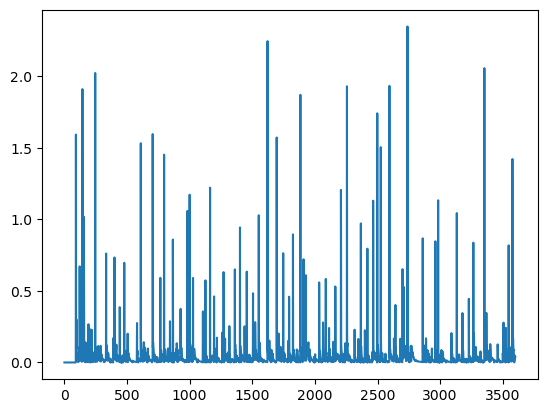

In [130]:
plt.plot(abs(velocity.values*(water_level_end-zbo)))
print(1000*float(sum((velocity.values*(water_level_end-zbo))))/3600)


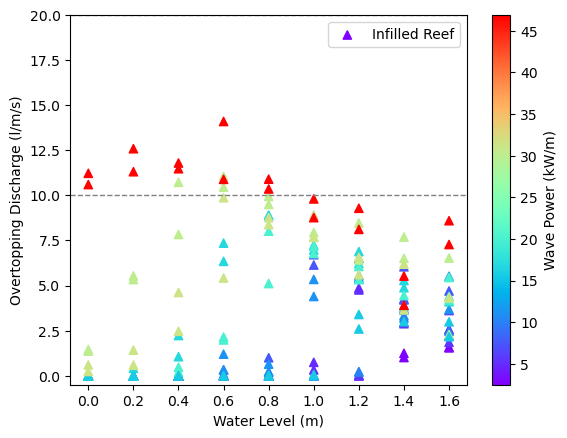

In [187]:
import matplotlib.pyplot as plt

# Extract data from the dictionary
wl_values = []
OD_values = []
Hs_values = []
Power_values = []
for key, output in overtop_dict.items():
    wl = float(key[-1])  # Extract the 'wl' value and convert it to float
    OD = 1000*output['OD'].item()  # Extract the 'OD' value as a float
    Hs = key[1]  # Extract the 'Hs' value from the key
    Tp = key[2]  # Extract the 'Hs' value from the key
    wl_values.append(wl)
    OD_values.append(OD)
    Power_values.append(Hs*Hs*Tp*0.5)

# Create the scatter plot
plt.scatter(wl_values, OD_values, c=Power_values, cmap='rainbow', label='Infilled Reef',marker='^')

# Set the labels and title
plt.xlabel('Water Level (m)')
plt.ylabel('Overtopping Discharge (l/m/s)')
# plt.title('Scatter Plot of Water Level vs. Output')
plt.axhline(y=10, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=20, color='gray', linestyle='--', linewidth=1)

# Add color bar
plt.colorbar(label='Wave Power (kW/m)')

# Show legend
plt.legend()
plt.ylim([-0.5,20])
# Show the plot
plt.show()

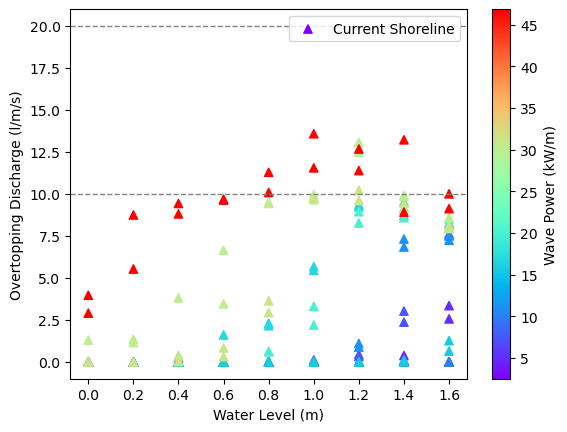

In [174]:
import matplotlib.pyplot as plt

# Extract data from the dictionary
wl_values = []
OD_values = []
Hs_values = []
Power_values = []
for key, output in overtop_dict.items():
    wl = float(key[-1])  # Extract the 'wl' value and convert it to float
    OD = 1000*output['OD'].item()  # Extract the 'OD' value as a float
    Hs = key[1]  # Extract the 'Hs' value from the key
    Tp = key[2]  # Extract the 'Hs' value from the key
    wl_values.append(wl)
    OD_values.append(OD)
    Power_values.append(Hs*Tp*Hs*0.5)

# Create the scatter plot
plt.scatter(wl_values, OD_values, c=Power_values, cmap='rainbow', label='Current Shoreline',marker='^')

# Set the labels and title
plt.xlabel('Water Level (m)')
plt.ylabel('Overtopping Discharge (l/m/s)')
# plt.title('Scatter Plot of Water Level vs. Output')
# Add horizontal dashed lines at y=10 and y=20
plt.axhline(y=10, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=20, color='gray', linestyle='--', linewidth=1)


# Add color bar
plt.colorbar(label='Wave Power (kW/m)')

# Show legend
plt.legend()

# Show the plot
plt.show()

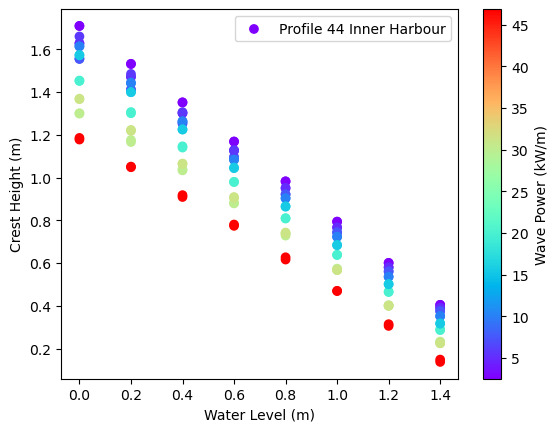

In [237]:
import matplotlib.pyplot as plt

# Extract data from the dictionary
wl_values = []
OD_values = []
Hs_values = []
Power_values = []
for key, output in results_dict.items():
    wl = float(key[-1])  # Extract the 'wl' value and convert it to float
    # OD = 1000*output['OD'].item()  # Extract the 'OD' value as a float
    Hs = key[1]  # Extract the 'Hs' value from the key
    Tp = key[2]  # Extract the 'Hs' value from the key
    Hm0= output['Hs'].item()  # Extract the 'Hs' value from the key
    Setup= output['Setup'].item()  # Extract the 'Hs' value from the key
    Rc=1.8-wl-Setup
    B=4
    # print(Tp)
    surf_similarity=np.tan(1.5)/np.sqrt(2*3.14159*Hm0/(9.81*Tp*Tp))
    
    Transmission_factor=-0.4*Rc/Hm0+(0.64*(B/Hm0)**(-0.31))*(1-np.exp(-0.5*surf_similarity))
    # Transmission_factor=min(0.075,Transmission_factor)
    # Transmission_factor=max(0.8,Transmission_factor)
    if Rc<0:
        Transmission_factor=1
       
    # print(Transmission_factor)
    Hm_inner=Hm0*Transmission_factor+0.6
    wl_values.append(wl)
    
    OD_values.append(Rc)
    Power_values.append(Hs*Hs*Tp*0.5)

# Create the scatter plot
plt.scatter(wl_values, OD_values, c=Power_values, cmap='rainbow', label='Profile 44 Inner Harbour')

# Set the labels and title
plt.xlabel('Water Level (m)')
plt.ylabel('Crest Height (m)')
# plt.title('Scatter Plot of Water Level vs. Output')
# plt.axhline(y=10, color='gray', linestyle='--', linewidth=1)
# plt.axhline(y=20, color='gray', linestyle='--', linewidth=1)

# Add color bar
plt.colorbar(label='Wave Power (kW/m)')
# plt.axhline(y=0.6, color='gray', linestyle='--', linewidth=1)
# Show legend
plt.legend()
# plt.ylim([-0.5,2.5])
# Show the plot
plt.show()